# How long is a day?
In this tutorial we will use an astronomical Python library to show how the length of a day varies during one year. Let's start from importing the ephem module and instantiating an observer:

In [1]:
import ephem
observer = ephem.Observer()

To set observer's localization we have to set the position on the Earth's surface:

In [2]:
observer.lat = "51.109454"
observer.lon = "17.032686"
observer.elev = 120
observer

<ephem.Observer date='2017/9/28 12:58:12' epoch='2000/1/1 12:00:00' lon='17:01:57.7' lat='51:06:34.0' elevation=120.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

We can see that the observer is related with a date when the object was created. We need all days in one year, so a good choice is to use the pandas module and its fixed frequency datetime index for the current year:

In [3]:
import pandas as pd

current_year = observer.date.triple()[0]
all_days = pd.date_range(str(current_year) + "/01/01", str(current_year) + "/12/31")
all_days

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

To calculate the length of a specific day we have to estimate time between the Sun rising and setting:

In [4]:
sun = ephem.Sun()
day_length = []

for ad in all_days:
    observer.date = ad
    day_length += [observer.next_setting(sun) - observer.next_rising(sun)]
    
days = 24.*pd.DataFrame(day_length, index=all_days, columns=["day length [hour]"])
days.head()

,day length [hour]
2017-01-01,8.017117
2017-01-02,8.037027
2017-01-03,8.058562
2017-01-04,8.081697
2017-01-05,8.106407


It's time to visualize obtained results. To do this we will use the matplotlib library:

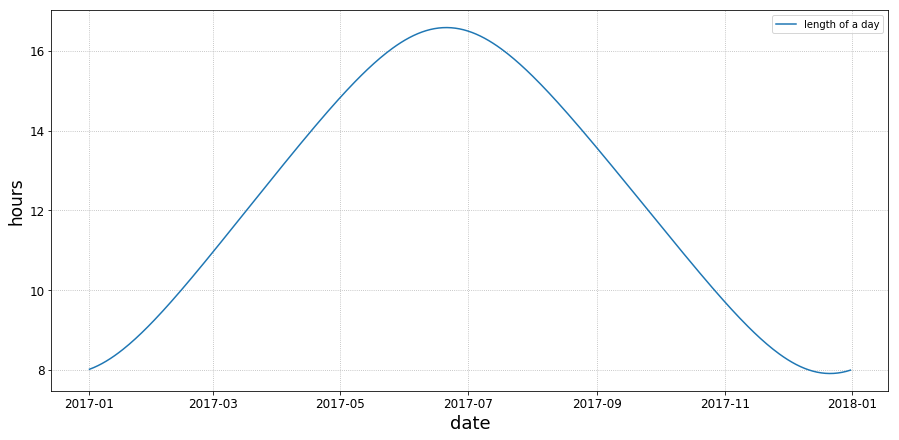

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(days.index, days.values)
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('length of a day',))
plt.show()

We can see that the curve increases and decreases the most rapidly around both equinoxes. It means that people can notice changes week-by-week.